# Citibike Stations' Inflow/Outflow Ratio
Group Members:
Cindy Y. Liu, Yuxiang Zhang

In [74]:
#Load Default settings
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline
import os
import json
from matplotlib import gridspec
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


In [49]:
# Load Citibike data
df = pd.read_csv(os.getenv ('PUI2015')+'/data/201508-citibike-tripdata.csv')

In [50]:
# Drop unnecessary features
df = df.drop(['tripduration','starttime','stoptime'],axis=1)

In [51]:
## Store the information of stations into a csv file. including longitude latitude, and id
start = pd.DataFrame({'ID': df['start station id'], \
                    'Latitude': df['start station latitude'],\
                    'Longitude':df['start station longitude']})
end = pd.DataFrame({'ID': df['end station id'], \
                    'Latitude': df['end station latitude'],\
                    'Longitude':df['end station longitude']})
merged = pd.concat([start,end],axis=0)
merged = merged.drop_duplicates('ID')
merged.to_csv('station.csv')   

We use the ** Geopy ** to [Reverse geocoding](https://en.wikipedia.org/wiki/Reverse_geocoding) the latitude and longitude information into a real street information. 

In [ ]:
from geopy.geocoders import Nominatim
import numpy as np
output= np.empty(len(stations), dtype='object')
for index,station in stations.iterrows():
    geolocator = Nominatim()
    location = geolocator.reverse("%s,%s"%(str(station['Latitude']), str(station['Longitude'])),timeout=10)
    if location.raw["address"]["county"]=="New York County"or location.raw["address"]["county"]=="New York":
        output[index]="Manhattan"
    else:
        if location.raw["address"]["county"]=="Kings County":
            output[index]="Brooklyn"
        else:
            if location.raw["address"]["county"]=="Queens County":
                output[index]="Queens"
            else:
                output[index]=location.raw["address"]["county"]

We get the borough information for each Citibike station and store the information into the stationbyborough.csv

In [ ]:
output.tofile('output.csv',sep='\n')

In [53]:
stations_by_borough=pd.read_csv('data/stationbyborough.csv')

In [71]:
in_jour = np.zeros(len(stations_by_borough))
out_jour = np.copy(in_jour)
in_out_ratio = np.copy(in_jour)

In [57]:
# Iterate through all the stations to get the total inflow and outflow information of each station
for index,station in stations_by_borough.iterrows():
    start=sum(df['start station id']==station['id'])
    end=sum(df['end station id']==station['id'])
    in_jour[index]=start
    out_jour[index]=end
    in_out_ratio[index]=start/float(end+start)

In [62]:
# Create a new data frame which includes all the inflow and outflow information of each station
results = pd.DataFrame({'sid':stations_by_borough['id'],\
                      'income':in_jour,\
                      'outcome':out_jour,\
                      'ratio':fluid_ratio,\
                      'borough':stations_by_borough['BoroName']})
cols = ['sid','income','outcome','ratio','borough']
results = results[cols]
results.to_csv('result.csv')

In [63]:
results.describe()

,sid,income,outcome,ratio
count,421.000000,421.000000,421.000000,421.000000
mean,1020.299287,2800.579572,2800.579572,0.496943
std,1143.676593,2478.491485,2437.574067,0.041569
min,72.000000,0.000000,1.000000,0.000000
25%,317.000000,674.000000,684.000000,0.492572
50%,434.000000,2486.000000,2419.000000,0.498966
75%,2001.000000,4276.000000,4296.000000,0.504762
max,3224.000000,14498.000000,11912.000000,0.654886


In [64]:
pd.value_counts(results['borough'].values.ravel())

Manhattan    262
Brooklyn     148
Queens        11
dtype: int64

## Statistic Analysis

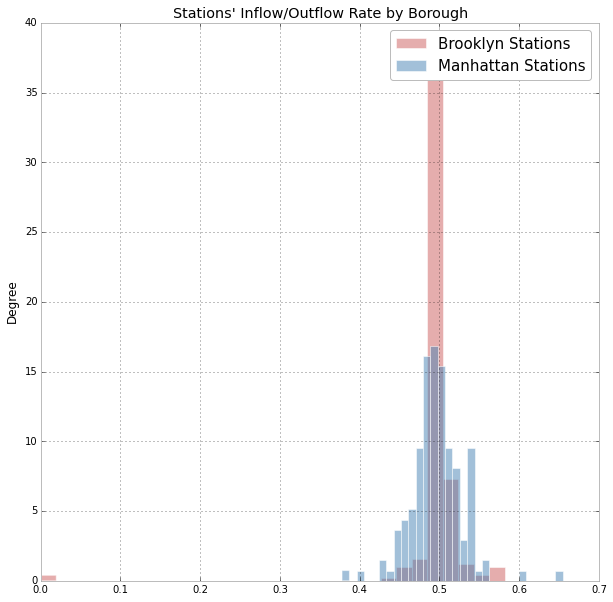

In [65]:
results=pd.read_csv('result.csv')
manhattan=results[results['borough']=='Manhattan']
brooklyn=results[results['borough']=='Brooklyn']

norm_m = 1
norm_b = 1

error_m = np.sqrt(manhattan['ratio'].count())
error_b = np.sqrt(brooklyn['ratio'].count())
fig = pl.figure(figsize(10,10))
manhattan['ratio'].plot(kind="hist",yerr=[((error_m)/norm_m,(error_m)/norm_m)],\
                        bins=30,color='IndianRed', alpha=0.5,label='Manhattan Stations',normed=1)
brooklyn['ratio'].plot(kind="hist",yerr=[((error_b)/norm_b,(error_b)/norm_b)],\
                       bins=30, alpha=0.5,label='Brooklyn Stations',normed=1)
pl.legend(['Brooklyn Stations','Manhattan Stations'],fontsize=15)
pl.title('Stations\' Inflow/Outflow Rate by Borough' )

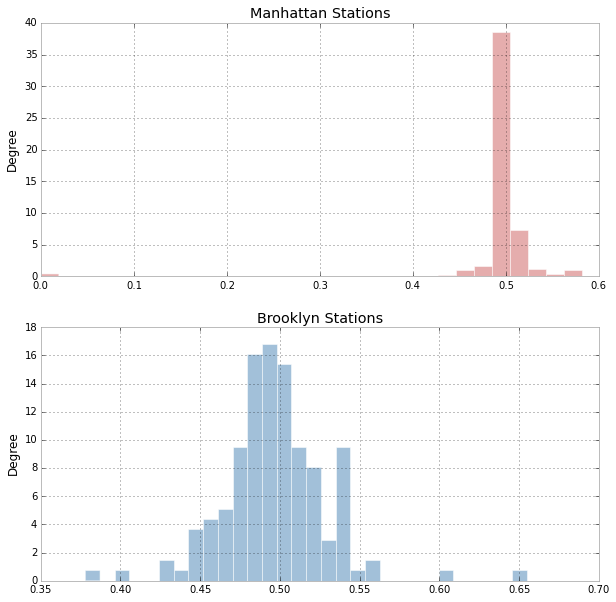

In [87]:
fig=pl.figure(figsize(10,10))
gs = gridspec.GridSpec(2, 1)
ax = fig.add_subplot(gs[0,0])
manhattan['ratio'].plot(kind="hist",yerr=[((error_m)/norm_m,(error_m)/norm_m)],\
                        bins=30,color='IndianRed', alpha=0.5,normed=1)
ax.set_title('Manhattan Stations')
bx = fig.add_subplot(gs[1,0])
brooklyn['ratio'].plot(kind="hist",yerr=[((error_b)/norm_b,(error_b)/norm_b)],\
                       bins=30, alpha=0.5,normed=1)
bx.set_title('Brooklyn Stations')

In [40]:
manhattan['ratio'].describe()

count    262.000000
mean       0.496891
std        0.046419
min        0.000000
25%        0.496087
50%        0.499318
75%        0.502410
max        0.581790
Name: ratio, dtype: float64

In [41]:
brooklyn['ratio'].describe()

count    148.000000
mean       0.496576
std        0.032732
min        0.377960
25%        0.480969
50%        0.495208
75%        0.512843
max        0.654886
Name: ratio, dtype: float64

# Hypothesis:

Manhattan has less inflow riders than Brooklyn.¶

# z test for mean ratio of two samples.

$H_{0} : mean_m-mean_b>0$

$H_{\alpha}: mean_m-mean_b<=0$

In [42]:
mean_m=np.mean(manhattan['ratio'])
mean_b=np.mean(brooklyn['ratio'])
std_m=np.std(manhattan['ratio'])
std_b=np.std(brooklyn['ratio'])
n_m=len(manhattan)
n_b=len(brooklyn)

SE=lambda sd1,sd2,n1,n2: np.sqrt(sd1**2/float(n1)+sd2**2/float(n2))
se=SE(std_m,std_b,n_m,n_b)

In [43]:
z_1=(mean_m-mean_b)/se
print z_1

0.0802738912184


In [44]:
p_1=0.5319
alpha =0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)

    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p_1,alpha)

Is the p value 0.38 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected


# Z test for the proportion of ration>1/ration_all in two samples.

$H_{0} : p_m-p_b>0$

$H_{\alpha}: p_m-p_b<=0$

In [67]:
P_0=sum(manhattan['ratio']>=0.5)/float(len(manhattan))
P_1=sum(brooklyn['ratio']>=0.5)/float(len(brooklyn))

n_0=len(manhattan)
n_1=len(brooklyn)

Nt_0 = P_0*n_0
Nt_1 = P_1*n_1
print (P_0, P_1, n_0, n_1)

# Pooled Sample Proportion
psp=(P_0*n_0+P_1*n_1)/(n_1+n_0)

SE= lambda p, n1, n2: np.sqrt(psp*(1-psp)*(1/float(n1)+1/float(n2)))

se=SE(P_0,n_0,n_1)

# Z-score
zscore = lambda p0, p1, s : (p0-p1)/s
z_2 = zscore(P_1, P_0, se)
print(z_2)

(0.42366412213740456, 0.4391891891891892, 262, 148)
0.305030069472


In [13]:
p = 1 - 0.6179
alpha =0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)
   
    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p,alpha)

Is the p value 0.38 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected
